# Прогнозирование температуры звезды

Обсерватория "Небо на ладони" хочет предсказыватьтемпературу звезды с помощью нейросети. Обычно для расчёта температуры учёные пользуются следующими методами:  
* Закон смещения Вина.
* Закон Стефана-Больцмана.
* Спектральный анализ.


**Цель:** придумать нейросеть для предсказания температуру звезды.   
**Задачи:**
1. Загрузка исходных данных из файла;
2. Исследовательский анализ данных;
3. Подготовка данных к построению модели;
4. Построение простой модели нейронной сети;
5. Улучшение сети;
6. Общий вывод.

# Описание данных

Данные находятся в файле `/datasets/6_class.csv`

**Признаки**

* Unnamed: 0 — порядковый номер звезды;
* Temperature (K) — абсолютная температура — температура на поверхности звезды в Кельвинах;
* Luminosity(L/Lo) — относительная светимость — светимость звезды относительно Солнца;
* Radius(R/Ro) — относительный радиус — радиус звезды относительно радиуса Солнца;
* Absolute magnitude(Mv) — абсолютная звёздная величина — физическая величина, характеризующая блеск звезды;
* Star type — тип звезды;
* Star color — звездный цвет.

# Шаг 1. Загрузка исходных данных из файла

In [1]:
!pip install torch
!pip install phik

     |████████████████████████████████| 677 kB 2.2 MB/s eta 0:00:01


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
import phik
import torch
import torch.nn as nn
import torch.optim as optim
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer

SEED = 42
RANDOM_STATE = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

In [3]:
try:
    df = pd.read_csv('/datasets/6_class.csv')
except:
    df = pd.read_csv('/Users/user/Desktop/Курсы/Яндекс/Модели и алгоритмы ML/6_class.csv')

In [4]:
df.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


### Промежуточный вывод

**Цель:** загрузить данные.   
1. Данные загружены в датафрейм `df`, состоящий из 7 строк и 240 столбцов.
2. Пропуски в данных не обнаружены, на первый взгляд данные корректные.

# Шаг 2. Исследовательский анализ данных

Типы данных корректные.    
Приведем названия столбцов к snake case.

In [6]:
df.columns = (df.columns.str.replace(r'\(.*?\)', '', regex=True).str.strip().str.lower().str.replace(' ', '_'))
print(df.columns)

Index(['unnamed:_0', 'temperature', 'luminosity', 'radius',
       'absolute_magnitude', 'star_type', 'star_color'],
      dtype='object')


Проверим на наличие явных дубликатов.

In [7]:
print(f'Количество выявленных явных дубликатов: {df.duplicated().sum()}')

Количество выявленных явных дубликатов: 0


Проведем исследовательский анализ данных.

In [8]:
def categorical_features(attribute, title='', top_n=10, show_pie=True):
    """
    Визуализация категориального признака:
    - Гистограмма
    - (опционально) Круговая диаграмма
    - Boxplot по признаку 'temperature'

    Параметры:
        attribute: str — Название категориального признака
        title: str — Заголовок
        top_n: int — Сколько категорий отображать
        show_pie: bool — Визуализировать ли круговую диаграмму
    """
    counts = df[attribute].value_counts().head(top_n)
    filtered_df = df[df[attribute].isin(counts.index)]

    n_rows = 3 if show_pie else 2
    fig, axes = plt.subplots(n_rows, 1, figsize=(10, 5 * n_rows))

    if n_rows == 2:
        ax_hist, ax_box = axes
    else:
        ax_hist, ax_pie, ax_box = axes

    sns.countplot(x=attribute, data=filtered_df, order=counts.index, ax=ax_hist, palette='viridis')
    ax_hist.set_title(f"{title} — Частоты")
    ax_hist.tick_params(axis='x', rotation=90)

    if show_pie:
        counts.plot.pie(autopct='%1.1f%%', ax=ax_pie, cmap='Pastel1')
        ax_pie.set_ylabel('')
        ax_pie.set_title(f"{title} — Доли")

    # Boxplot
    sns.boxplot(x=attribute, y='temperature', data=filtered_df, order=counts.index, ax=ax_box, palette='Set3')
    ax_box.set_title(f"{title} — Температура по категориям")
    ax_box.tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

    print(counts)

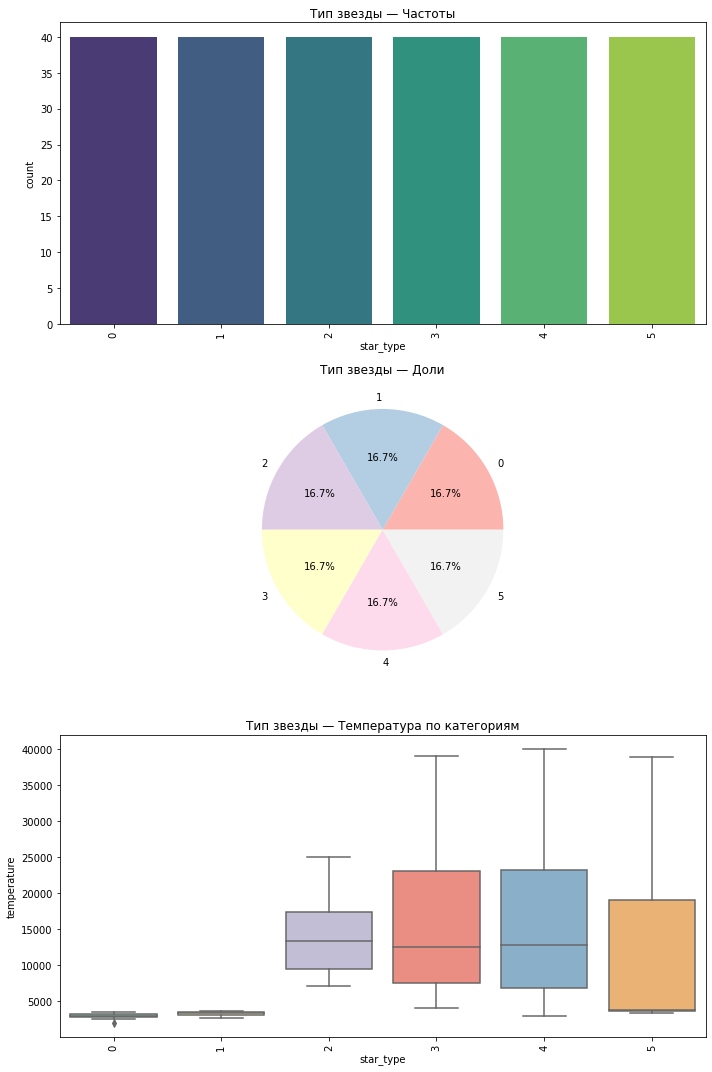

0    40
1    40
2    40
3    40
4    40
5    40
Name: star_type, dtype: int64


In [9]:
categorical_features('star_type', 'Тип звезды')

Типы звезд представлены в одинаковом количестве по 40 штук. Наиболее высокая средняя температура у звезд типов 4 и 3.

In [10]:
print(f"Уникальные значения: {df['star_color'].unique()}")
print(f"Количество уникальных значений: {df['star_color'].nunique()}")

Уникальные значения: ['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'Blue ' 'yellowish' 'Yellowish'
 'Orange-Red' 'Blue white ' 'Blue-White']
Количество уникальных значений: 19


Обнаружены неявные дубликаты в столбце `star_color`. Исправим.

In [11]:
df['star_color'] = df['star_color'].str.strip().str.lower().str.replace('-', ' ').str.replace('_', ' ')

print(f"Уникальные значения: {df['star_color'].unique()}")
print(f"Количество уникальных значений: {df['star_color'].nunique()}")

Уникальные значения: ['red' 'blue white' 'white' 'yellowish white' 'pale yellow orange' 'blue'
 'whitish' 'yellow white' 'orange' 'white yellow' 'yellowish' 'orange red']
Количество уникальных значений: 12


Согласно Гарвардская спектральная классификации созданной в 1890-1924 годах существует 7 типов цветности звезд. Откорректируем категории чтобы они согласовывались со спектральной классификацией.

In [12]:
def star_color(color):
    """
    Преобразует нестандартизованные цвета звёзд в группы
    по Гарвардской классификации.

    Возвращает один из: blue, blue-white, white, yellow-white, yellow, orange, red
    """
    color = color.lower().strip()

    if color in ['blue']:
        return 'blue'
    elif color in ['blue white']:
        return 'blue-white'
    elif color in ['white', 'whitish']:
        return 'white'
    elif color in ['yellow white', 'white yellow']:
        return 'yellow-white'
    elif color in ['yellowish', 'yellowish white']:
        return 'yellow'
    elif color in ['orange', 'pale yellow orange']:
        return 'orange'
    elif color in ['red', 'orange red']:
        return 'red'
    else:
        return 'other'
    
df['star_color'] = df['star_color'].apply(star_color)

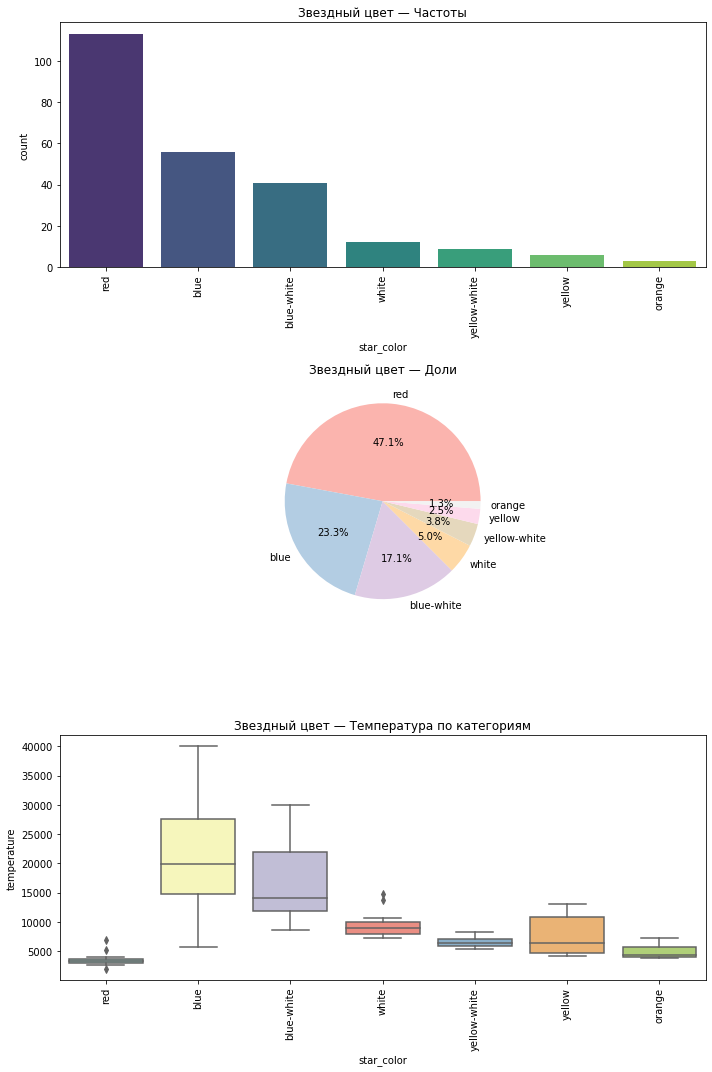

red             113
blue             56
blue-white       41
white            12
yellow-white      9
yellow            6
orange            3
Name: star_color, dtype: int64


In [13]:
categorical_features('star_color', 'Звездный цвет', top_n=12)

Звездный цвет представлен большим количеством категорий. Наиболее популярная категория - red(47.1% данных), затем звезды blue. Категория red имеет наиболее низкие значения температуры, а blue наоборот, самые высокие. Самая редкая цветность - оранжевая.

In [14]:
def quantitative_features(attribute, title='', bins=20):
    """
    Визуализация количественного признака:
    - Если attribute == 'price': гистограмма и один boxplot
    - Иначе: гистограмма и boxplot по квантильным интервалам температуры

    Параметры:
        df: DataFrame
        attribute: Название числового признака
        title: Заголовок графиков
        bins: Кол-во бинов в гистограмме
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    sns.histplot(df[attribute], kde=True, bins=bins, ax=ax[0], color='steelblue')
    ax[0].set_title(f'{title} - распределение', fontsize=14)
    ax[0].set_xlabel(attribute)
    ax[0].set_ylabel('Количество')

    if attribute == 'temperature':
        sns.boxplot(x=df[attribute], ax=ax[1], color='lightgreen')
        ax[1].set_title(f'{title} - boxplot', fontsize=14)
        ax[1].set_xlabel(attribute)
    else:
        df['tempurature_bin'] = pd.qcut(df['temperature'], q=5, duplicates='drop')
        sns.boxplot(x='tempurature_bin', y=attribute, data=df, palette='Pastel2', ax=ax[1])
        ax[1].set_title(f'{title} - по интервалам температуры', fontsize=14)
        ax[1].set_xlabel('Интервалы температуры')
        ax[1].tick_params(axis='x', rotation=45)
        df.drop(columns='tempurature_bin', inplace=True)

    plt.tight_layout()
    plt.show()

    print(df[attribute].describe())

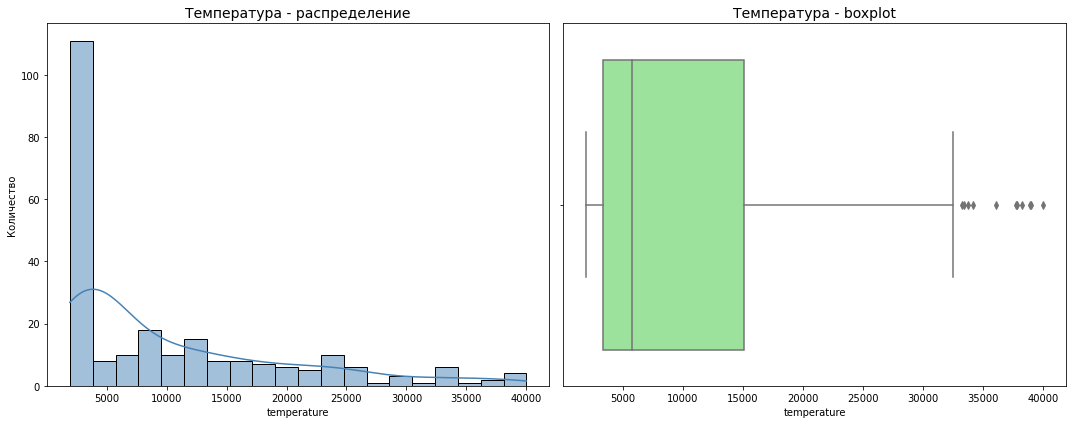

count      240.000000
mean     10497.462500
std       9552.425037
min       1939.000000
25%       3344.250000
50%       5776.000000
75%      15055.500000
max      40000.000000
Name: temperature, dtype: float64


In [15]:
quantitative_features('temperature', 'Температура')

Целевой признак - температура на поверхности звезды измеряемая в Кельвинах. По гистограмме видно, что температура до 5000 Кельвинов наблюдается более чем в 100 случаях, думаю, что это те самые 112 звезд цветности Red, которые имеют самую низкую температуру. Данный факт логичен, так как это соответсвует закону Вина, котороый гласит, что чем ниже температура звезды, тем длиннее (краснее) длина волны излучения. А так, в основном, значения температуры колеблются от 3500 до 15000 Кельвинов. Так же имеется некоторое количество звезд с температурой более 35000 Кельвинов.

In [16]:
df_red = df.query('temperature > 5000 & star_color == "red"')
df_red

,unnamed:_0,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
96,96,5112,0.63,0.876,4.68,3,red
118,118,6850,229000.00,1467.000,-10.07,5,red


In [17]:
df_1 = df.query('temperature < 5000 & star_color == "red" & star_type == 1')
len(df_1)

40

Все совпало, те 111 значений у которых температура менее 5000 Кельвинов имеют цветность red, лишь одна звезда цветности red имеет температуру более 6850 Кельвинов. 40 звезд с температурой менее 5000 Кльвинов являются красными карликами.

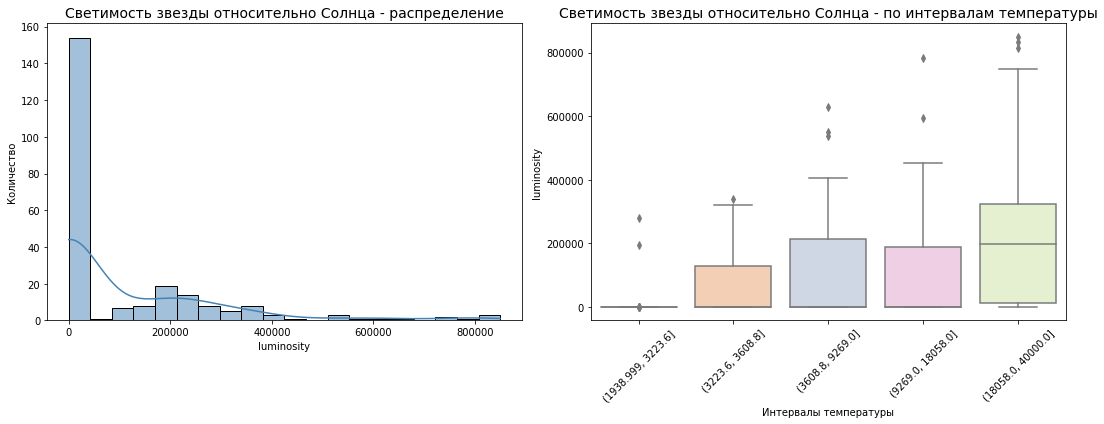

count       240.000000
mean     107188.361635
std      179432.244940
min           0.000080
25%           0.000865
50%           0.070500
75%      198050.000000
max      849420.000000
Name: luminosity, dtype: float64


In [18]:
quantitative_features('luminosity', 'Светимость звезды относительно Солнца')

По ящику с усами можно смело заявить, что чем выше температура, тем выше светимость звезды относительно Солнца. Правда, более половины звёзд в выборке имеют светимость до 1 — то есть не превышающую светимость Солнца (единица измерения здесь — L/Lo, где Lo — светимость Солнца). В то же время в данных присутствуют и гипергиганты, чья светимость превышает солнечную в сотни тысяч раз — именно они обладают самой высокой температурой поверхности из всех звёзд в выборке.

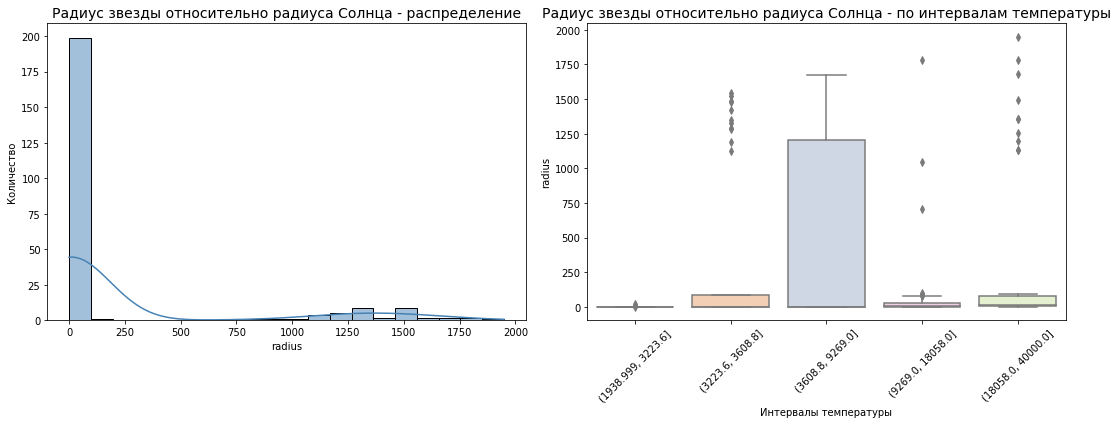

count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: radius, dtype: float64


In [19]:
quantitative_features('radius', 'Радиус звезды относительно радиуса Солнца')

Самые холодные и самые горячие звёзды — маленькие, скорее всего это красные и белые карлики. Среднетемпературные звёзды — самые крупные, к ним относятся сверхгиганты и гипергиганты. Распределение радиуса звезды зависит от температуры нелинейно — одной температуры недостаточно, чтобы точно предсказать радиус.

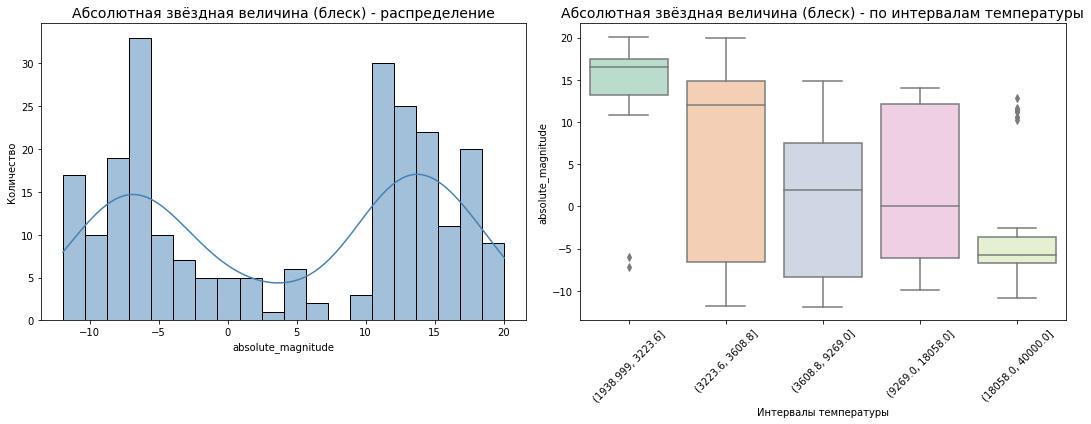

count    240.000000
mean       4.382396
std       10.532512
min      -11.920000
25%       -6.232500
50%        8.313000
75%       13.697500
max       20.060000
Name: absolute_magnitude, dtype: float64


In [20]:
quantitative_features('absolute_magnitude', 'Абсолютная звёздная величина (блеск)')

Явно заметно, что чем ярче звезда, тем выше ее температура. Наши данные представлены и суперяркой звездой (-11.9) и тусклыми звездами (20). 

Корреляционный анализ. Исследуем зависимости признаков.

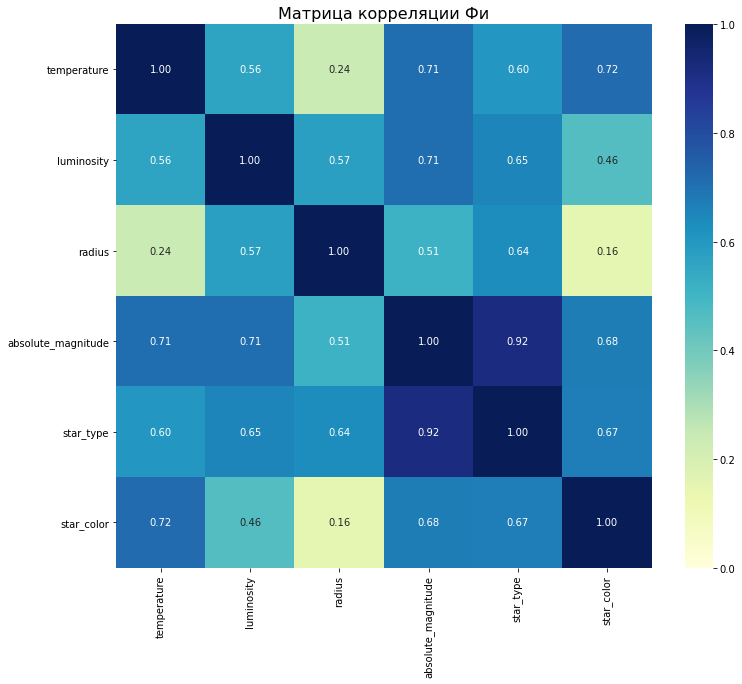

In [21]:
columns_to_drop = ['unnamed:_0']
df_phik = df.drop(columns=columns_to_drop).dropna()

interval_cols = ['temperature', 'luminosity', 'radius', 'absolute_magnitude']
phik_overview = df_phik.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(12, 10)) 
sns.heatmap(phik_overview, annot=True, fmt='.2f', cmap='YlGnBu', vmin=0, vmax=1)
plt.title('Матрица корреляции Фи', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [22]:
phik_overview

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
temperature,1.000000,0.562667,0.236637,0.710472,0.603924,0.715924
luminosity,0.562667,1.000000,0.574964,0.709456,0.654026,0.463529
radius,0.236637,0.574964,1.000000,0.512414,0.635115,0.156038
absolute_magnitude,0.710472,0.709456,0.512414,1.000000,0.915921,0.675046
star_type,0.603924,0.654026,0.635115,0.915921,1.000000,0.667981
star_color,0.715924,0.463529,0.156038,0.675046,0.667981,1.000000


Признаки имеют зависимость друг от дргуа выше умеренной, кроме зависимости радиуса от температуры и радиуса, и  радиуса от цветности звезды. Между абсолютной звездной велечиной(блеском) и типом звезды присутсвует мультиколлинеарность. Что подтверждается формулами, которые использовали ученые:
- Закон Стефана-Больцмана (L ∝ R²T⁴) подтверждает наличие связи между светимостью, радиусом и температурой.
- Закон смещения Вина (λ_max ∝ 1/T) объясняет зависимость цвета звезды от её температуры.
- Спектральный анализ определяет цвет и состав звезды, что есть в признаке `star_color`.

Text(0.5, 0.98, 'Диаграммы рассеяния по типу звезды')

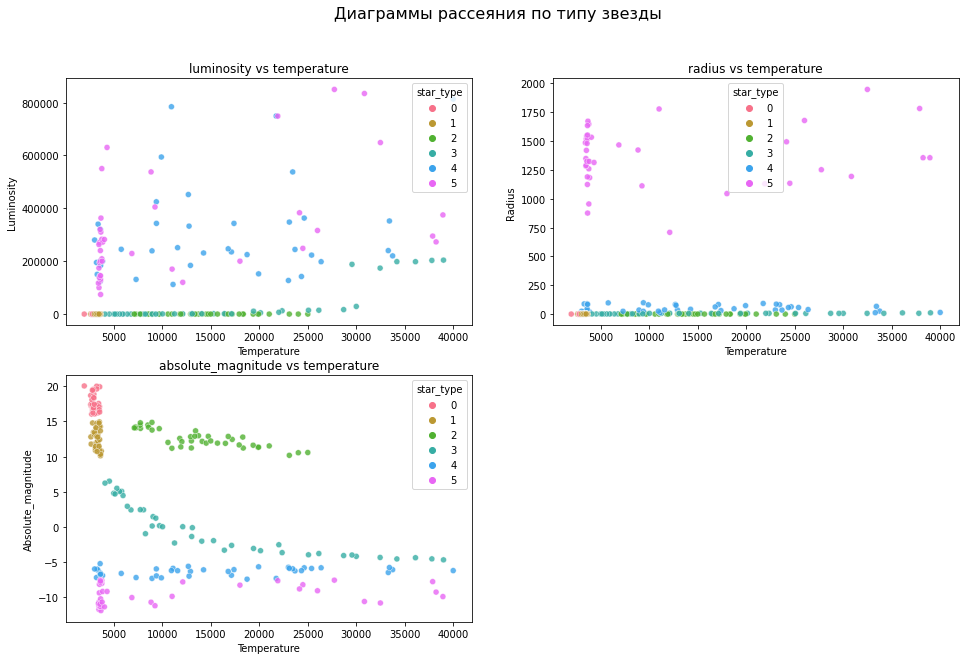

In [23]:
features = [
    ('temperature', 'luminosity'),
    ('temperature', 'radius'),
    ('temperature', 'absolute_magnitude')
]


palette = sns.color_palette("husl", len(df['star_type'].unique()))

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, (x, y) in enumerate(features):
    sns.scatterplot(
        data=df,
        x=x,
        y=y,
        hue='star_type',
        palette=palette,
        alpha=0.8,
        ax=axes[i]
    )
    axes[i].set_title(f'{y} vs {x}')
    axes[i].set_xlabel(x.capitalize())
    axes[i].set_ylabel(y.capitalize())

fig.delaxes(axes[-1])

plt.suptitle('Диаграммы рассеяния по типу звезды', fontsize=16)

Каждый тип звезды чётко отделяется от остальных по комбинации температуры, светимости и радиуса, что подтверждает информативность выбранных признаков.
Четко видна необходимость залогарифмировать признаки luminosity и radius из-за наличия большого количества значений в диапазоне от 0 до 1 и наличием сильных выбросов.
 * `luminosity` - тип 5 имеет более высокую светимость, чем остальные типы, так же имеет большой разборс температур; типы 0, 1 и 2 имеют низкую светимость и малый разброс температур, типы 3 и 4 низская светимость и большой разброс температур.
 * `radius` - тип 5 имеет самыфе высокие значения радиуса, так же рзброс по температуре; все остальные типы имеют небольшие значения радиуса, тип 3 и 4 имеют разброс в температуре.
 * `absolute_magnitude` - подтверждается, что чем меньше звезда, тем тусклее; звезды 1 и 2 типа холодные и тусклые, а остальные типы имеют сильный разброс температур.

### Промежуточный вывод

**Цель:** провести исследовательский анализ данных.   
1. Типы данных соответствуют содержанию. Приведены названия столбцов к snake_case. Выявлено 0 явных дубликатов. Обнаружены неявные дубликаты в столбце `star_color` — исправлены.
2. Каждый из 6 типов звёзд представлен в равном количестве (по 40 объектов). Цвета звёзд представлены с высокой категориальной разреженностью; наиболее распространён — red (46.7% наблюдений).
3. Более 100 объектов имеют температуру ниже 5000 К. Основной диапазон температур: от 3500 до 15000 К.
4. Чем выше температура, тем выше светимость звезды (L/Lo). Более половины звёзд имеют светимость ниже 1 (т.е. слабее Солнца) — в основном, это красные карлики.
5. Самые холодные и самые горячие звёзды — маленькие. Самые крупные звёзды имеют средние температуры — это сверхгиганты и гипергиганты.
7. Почти все признаки демонстрируют зависимость выше средней. Обнаружена мультиколлинеарность между абсолютной звёздной величиной и типом звезды.

# Шаг 3. Подготовка данных к построению модели

По результатам исследовательского анализа были внесены следующие корректировки:

1. Приведены названия столбцов к формату `snake_case` для единообразия.
2. Обнаружены неявные дубликаты в категориальном признаке `star_color` (например, "Red ", "red", "RED"), приведены к нижнему регистру и очищены от пробелов.
3. Пропущенные значения и дубликаты строк отсутствуют.
4. Все признаки содержат корректные типы данных.
5. Значения, визуально выглядевшие как выбросы, были проверены: они соответствуют допустимым астрономическим характеристикам (например, высокая светимость у гипергигантов), поэтому не были удалены.

Категоризация числовых признаков:
- `star_type` уже является категориальным признаком в числовом виде.
- `luminosity`, `radius` являются количественными переменными, которые имеют сильный разброс значений, чтобы снизить влияние экстремальных значений и стабилизировать перед масштабированием, применим логарифмическое преобразование.

In [24]:
df = df.set_index('unnamed:_0')
df['luminosity'] = np.log1p(df['luminosity'])
df['radius']     = np.log1p(df['radius'])

df.head(5)

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
unnamed:_0,,,,,,
0,3068,0.002397,0.157004,16.12,0,red
1,3042,0.000500,0.143407,16.60,0,red
2,2600,0.000300,0.097127,18.70,0,red
3,2800,0.000200,0.148420,16.65,0,red
4,1939,0.000138,0.098034,20.06,0,red


In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['temperature']),
    df['temperature'],
    test_size=0.3,
    shuffle=True,
    stratify=df['star_color'],   
    random_state=RANDOM_STATE
)


In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(168, 5)
(72, 5)
(168,)
(72,)


In [27]:
numeric_features = ['radius', 'luminosity', 'absolute_magnitude']
categorical_features = ['star_color','star_type'] 

try:
    ohe = OneHotEncoder(handle_unknown='error', sparse_output=False, drop='first')
except TypeError:
    ohe = OneHotEncoder(handle_unknown='error', sparse=False, drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', ohe, categorical_features)
    ]
)
X_train_processed = preprocessor.fit_transform(X_train)

X_test_processed = preprocessor.transform(X_test)

X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [28]:
print(X_train_tensor.shape)
print(X_test_tensor.shape)
print(y_train_tensor.shape)
print(y_test_tensor.shape)

torch.Size([168, 14])
torch.Size([72, 14])
torch.Size([168, 1])
torch.Size([72, 1])


В результате кодирования и масштабирования признаков получилось в тренирововчной выборке 14 столбцов из 5.

### Промежуточный вывод

**Цель:** подготовка данных к построению модели.
1. Столбец `unnamed:_0` переведен в индекс.
3. Столбцы `luminosity`, `radius` залогарифмированы для стабилизации масштабов значений.
4. Данные разбиты на тренировочные и тестовые выборки, затем подвергнуты масштабированию и кодированию, переведены в единые тензоры.

# Шаг 4. Построение простой модели нейронной сети

Определим нейронную сеть с произвольным числом скрытых слоёв и активацией ReLU, где для первого слоя из трёх используется линейная функция активации, для выходного тоже линейная функция активации.

In [29]:
class NET(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        layers = []
        prev = input_dim

        for i, h in enumerate(hidden_dims):
            layers.append(nn.Linear(prev, h))

            if len(hidden_dims) == 3 and i == 0:
                layers.append(nn.Identity())
            else:
                layers.append(nn.ReLU())

            prev = h
# для выходного слоя линейная функция активации
        layers.append(nn.Linear(prev, output_dim))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

Напишем функцию обучения модели с выводом метрик каждые 100 эпох: функция потерь и RMSE на тренировочной выборке.

In [30]:
def train_model(model, optimizer, loss_fn, X, y, epochs=1000):
    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            rmse = np.sqrt(mean_squared_error(y.detach().numpy(), y_pred.detach().numpy()))
            print(f"Epoch {epoch:4d} | MSE: {loss.item():.2f} | RMSE (train): {rmse:.0f} K")

Обучим однослойную нейронную сеть с 128 нейронами; рассчитаем и выведем RMSE на тестовой выборке.

In [31]:
model = NET(input_dim=X_train_tensor.shape[1],
            hidden_dims=[128],
            output_dim=1)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
X =  X_train_tensor
y = y_train_tensor

train_model(model, optimizer, loss_fn, X, y)

model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    rmse_test = np.sqrt(mean_squared_error(y_test_tensor.numpy(), y_pred_test.numpy()))
    print(f"Test RMSE: {rmse_test:.2f}")

Epoch  100 | MSE: 200030032.00 | RMSE (train): 14143 K
Epoch  200 | MSE: 159066496.00 | RMSE (train): 12612 K
Epoch  300 | MSE: 114894008.00 | RMSE (train): 10719 K
Epoch  400 | MSE: 84768120.00 | RMSE (train): 9207 K
Epoch  500 | MSE: 67855720.00 | RMSE (train): 8237 K
Epoch  600 | MSE: 56016908.00 | RMSE (train): 7484 K
Epoch  700 | MSE: 48962396.00 | RMSE (train): 6997 K
Epoch  800 | MSE: 44597064.00 | RMSE (train): 6678 K
Epoch  900 | MSE: 40979816.00 | RMSE (train): 6402 K
Epoch 1000 | MSE: 37887492.00 | RMSE (train): 6155 K
Test RMSE: 6310.58


Добавим второй скрытый слой.

In [32]:
model_2 = NET(input_dim=X_train_tensor.shape[1],
            hidden_dims=[128, 64],
            output_dim=1)
optimizer_2 = optim.Adam(model_2.parameters(), lr=1e-2)

train_model(model_2, optimizer_2, loss_fn, X, y)

model_2.eval()
with torch.no_grad():
    y_pred_test_2 = model_2(X_test_tensor)
    rmse_test = np.sqrt(mean_squared_error(y_test_tensor.numpy(), y_pred_test_2.numpy()))
    print(f"Test RMSE: {rmse_test:.2f}")

Epoch  100 | MSE: 68056312.00 | RMSE (train): 8250 K
Epoch  200 | MSE: 37451404.00 | RMSE (train): 6120 K
Epoch  300 | MSE: 20338198.00 | RMSE (train): 4510 K
Epoch  400 | MSE: 14993094.00 | RMSE (train): 3872 K
Epoch  500 | MSE: 14227444.00 | RMSE (train): 3772 K
Epoch  600 | MSE: 13889158.00 | RMSE (train): 3727 K
Epoch  700 | MSE: 13636640.00 | RMSE (train): 3693 K
Epoch  800 | MSE: 13440146.00 | RMSE (train): 3666 K
Epoch  900 | MSE: 13263144.00 | RMSE (train): 3642 K
Epoch 1000 | MSE: 12990357.00 | RMSE (train): 3604 K
Test RMSE: 3884.86


RMSE ещё снизилось, добавим третий слой.

In [33]:
model_3 = NET(input_dim=X_train_tensor.shape[1],
            hidden_dims=[128,64,32],
            output_dim=1)

optimizer_3 = optim.Adam(model_3.parameters(), lr=1e-2)

train_model(model_3, optimizer_3, loss_fn, X, y)

model_3.eval()
with torch.no_grad():
    y_pred_test_3 = model_3(X_test_tensor)
    rmse_test = np.sqrt(mean_squared_error(y_test_tensor.numpy(), y_pred_test_3.numpy()))
    print(f"Test RMSE: {rmse_test:.2f}")

Epoch  100 | MSE: 39336852.00 | RMSE (train): 6272 K
Epoch  200 | MSE: 15572131.00 | RMSE (train): 3946 K
Epoch  300 | MSE: 14294898.00 | RMSE (train): 3781 K
Epoch  400 | MSE: 13756780.00 | RMSE (train): 3709 K
Epoch  500 | MSE: 13451330.00 | RMSE (train): 3668 K
Epoch  600 | MSE: 13108139.00 | RMSE (train): 3621 K
Epoch  700 | MSE: 12712315.00 | RMSE (train): 3565 K
Epoch  800 | MSE: 12564660.00 | RMSE (train): 3545 K
Epoch  900 | MSE: 12482238.00 | RMSE (train): 3533 K
Epoch 1000 | MSE: 12408674.00 | RMSE (train): 3523 K
Test RMSE: 3668.31


Три слоя показали лучший результат. Остановимся на модели 3.

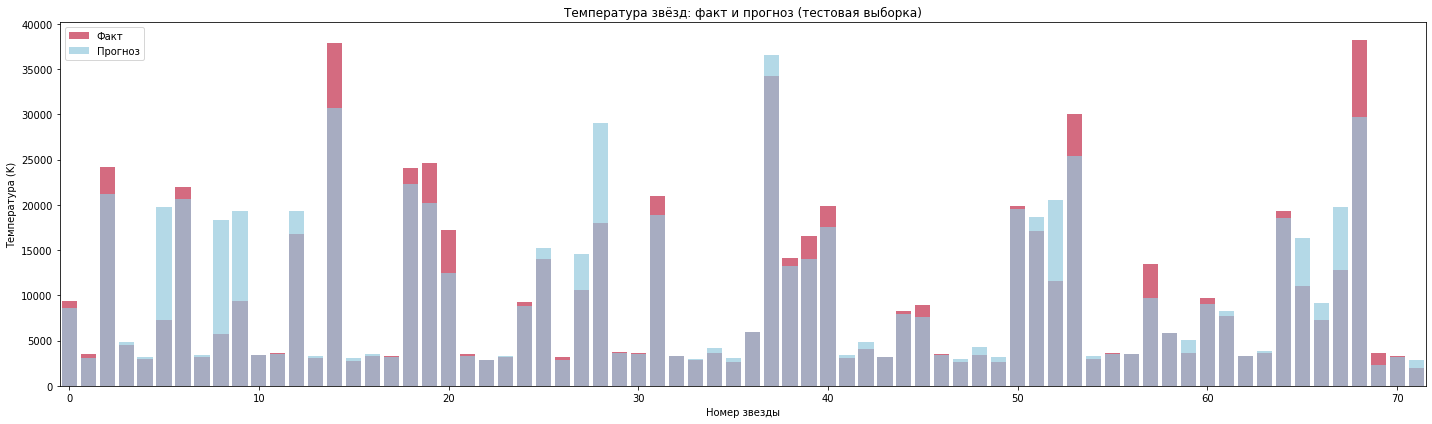

In [34]:
preds_test = y_pred_test_3.detach().numpy().flatten()
actuals_test = y_test_tensor.numpy().flatten()

df_plot = pd.DataFrame({
    'Звезда':   np.arange(len(actuals_test)),
    'Факт':     actuals_test,
    'Прогноз':  preds_test
})

plt.figure(figsize=(20, 6))
sns.barplot(
    x='Звезда',
    y='Факт',
    data=df_plot,
    color='crimson',
    alpha=0.7,
    label='Факт'
)
sns.barplot(
    x='Звезда',
    y='Прогноз',
    data=df_plot,
    color='skyblue',
    alpha=0.7,
    label='Прогноз'
)

xticks = np.arange(0, len(df_plot), 10)
plt.xticks(xticks, xticks)
plt.title('Температура звёзд: факт и прогноз (тестовая выборка)')
plt.xlabel('Номер звезды')
plt.ylabel('Температура (K)')
plt.legend()
plt.tight_layout()
plt.show()

Видно, что модель немного боится предсказывать экстремально высокие значения, что характерно для функции потерь MSE.

### Промежуточный вывод

**Цель:** построить простую модель нейронной сети.
1. Создано три модели: с одним, двумя и тремя скрытыми слоями - model, model_2, model_3.
2. У всех моделей функциями активации являлась ReLU, кроме model_3 у которой на первом слое линейная функция активации.
3. На выходном слое у всех моделей функцией активации являлась линейная.
4. Шаг обучения составлял 0.01 на всех моделях.
5. Значения RMSE на тестовой выборке с добавлением слоев опускались, минимум у model_3 = 3668.33. 
6. По графику предсказаний и фактических значений видно, что модель плохо предсказывает экстремально высокие значения.

# Шаг 5. Улучшение сети

Создадим нейросеть с тремя скрытыми слоями по архитектуре model_3, добавим dropout. Обучим с использованием градиентного спуска.

In [35]:
class BaseLineNet(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, output_dim,
                 dropout=0.0):
        super(BaseLineNet, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.act1 = nn.Identity()

        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(hidden_dim_2, hidden_dim_3)
        self.act3 = nn.ReLU()

        self.dropout = nn.Dropout(dropout)
        self.fc4 = nn.Linear(hidden_dim_3, output_dim)

    def forward(self, x):
        
        x = self.fc1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.act3(x)

        x = self.dropout(x)
        x = self.fc4(x)
        return x
        
def train_and_evaluate(model, X_train, y_train, X_test, y_test, batch_size, epochs, lr, weight_decay):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    best_rmse = float("inf")
    best_epoch = 0
    n_samples = len(X_train)
    num_batches = int(np.ceil(n_samples / batch_size))

    for epoch in range(epochs):
        model.train()
        order = np.random.permutation(n_samples)

        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            batch_indexes = order[start_index:start_index + batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            optimizer.zero_grad()
            preds = model(X_batch)
            loss_value = loss_fn(preds, y_batch)
            loss_value.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0 or (epoch + 1) == epochs:
            model.eval()
            with torch.no_grad():
                test_preds = model(X_test)
                rmse = torch.sqrt(loss_fn(test_preds, y_test))
                if rmse < best_rmse:
                    best_rmse = rmse.item()
                    best_epoch = epoch + 1

    return best_rmse, best_epoch

Проведем перебор гиперпараметров (dropout, размер батча, скорость обучения, weight decay) с обучением и оценкой модели, результаты сохраним в `df_results` и отсортируем по лучшему RMSE.

In [36]:
dropout_values = [0.0, 0.2, 0.3, 0.4]
batch_sizes = [4, 8, 16, 32, 64]
learning_rates = [1e-2, 1e-3, 5e-2]
weight_decays = [0.0, 1e-4]

records = []

for d in dropout_values:
    for b in batch_sizes:
        for lr in learning_rates:
            for wd in weight_decays:
                model = BaseLineNet(
                    input_dim=X_train_tensor.shape[1],
                    hidden_dim_1=128,
                    hidden_dim_2=64,
                    hidden_dim_3=32,
                    output_dim=1,
                    dropout=d
                )

                rmse, epoch = train_and_evaluate(
                    model,
                    X_train_tensor, y_train_tensor,
                    X_test_tensor, y_test_tensor,
                    batch_size=b,
                    epochs=300,
                    lr=lr,
                    weight_decay=wd
                )

                records.append({
                    "dropout": d,
                    "batch_size": b,
                    "lr": lr,
                    "weight_decay": wd,
                    "best_rmse": f"{rmse:.2f}",
                    "best_epoch": epoch
                })


df_results = pd.DataFrame(records).sort_values("best_rmse")
df_results.head(10)

,dropout,batch_size,lr,weight_decay,best_rmse,best_epoch
41,0.2,8,0.05,0.0001,3400.57,300
35,0.2,4,0.05,0.0001,3519.82,230
94,0.4,4,0.05,0.0000,3531.68,90
107,0.4,16,0.05,0.0001,3551.16,300
46,0.2,16,0.05,0.0000,3552.68,290
10,0.0,8,0.05,0.0000,3558.21,270
90,0.4,4,0.01,0.0000,3562.95,270
77,0.3,16,0.05,0.0001,3575.29,150
5,0.0,4,0.05,0.0001,3589.37,240
83,0.3,32,0.05,0.0001,3594.87,250


Извлечем параметры лучшей модели и обучим модель.

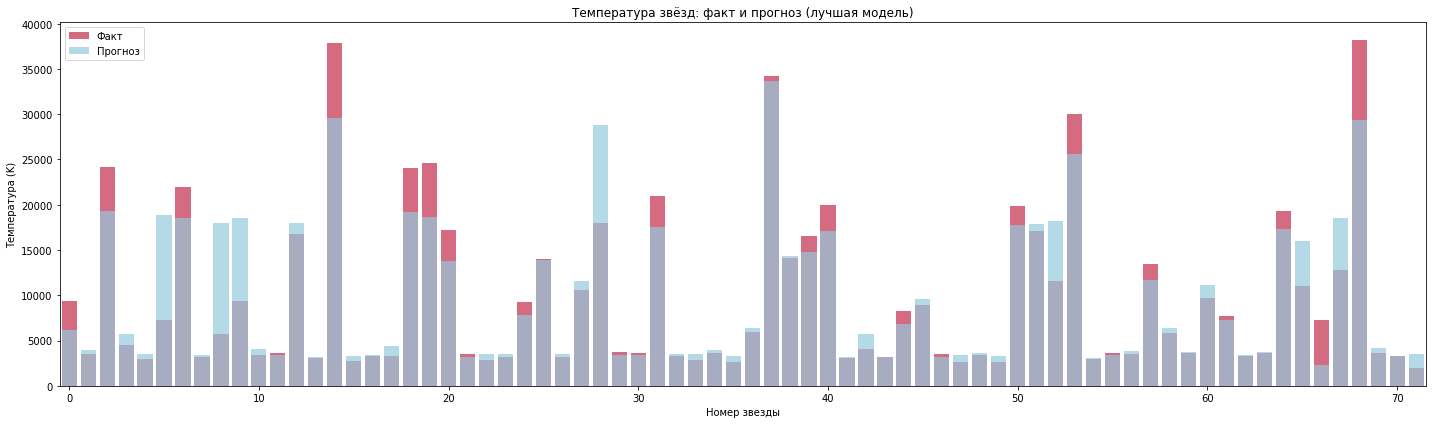

In [37]:
best_params = df_results.iloc[0]
d = best_params["dropout"]
b = int(best_params["batch_size"])
lr = best_params["lr"]
wd = best_params["weight_decay"]

best_model = BaseLineNet(
    input_dim=X_train_tensor.shape[1],
    hidden_dim_1=128,
    hidden_dim_2=64,
    hidden_dim_3=32,
    output_dim=1,
    dropout=d
)

train_and_evaluate(
    best_model,
    X_train_tensor, y_train_tensor,
    X_test_tensor, y_test_tensor,
    batch_size=b,
    epochs=300,
    lr=lr,
    weight_decay=wd
)

best_model.eval()
with torch.no_grad():
    y_pred_test_best = best_model(X_test_tensor)

preds_best = y_pred_test_best.detach().numpy().flatten()
actuals_test = y_test_tensor.numpy().flatten()

df_plot = pd.DataFrame({
    'Звезда':   np.arange(len(actuals_test)),
    'Факт':     actuals_test,
    'Прогноз':  preds_best
})

plt.figure(figsize=(20, 6))
sns.barplot(x='Звезда', y='Факт', data=df_plot, color='crimson', alpha=0.7, label='Факт')
sns.barplot(x='Звезда', y='Прогноз', data=df_plot, color='skyblue', alpha=0.7, label='Прогноз')
plt.xticks(np.arange(0, len(df_plot), 10), np.arange(0, len(df_plot), 10))
plt.title('Температура звёзд: факт и прогноз (лучшая модель)')
plt.xlabel('Номер звезды')
plt.ylabel('Температура (K)')
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
final = {
    "Модель": [
        "model",
        "model_2",
        "model_3",
        "model_3 + dropout + гиперпараметры"
    ],
    "Кол-во слоёв": [1, 2, 3, 3],
    "Активация на первом слое": ["ReLU", "ReLU", "Identity", "Identity"],
    "Dropout": [0.0, 0.0, 0.0, 0.2],
    "Лучший RMSE (тест)": [6310, 3886, 3668, 3416],
    "Лучшая эпоха": [1000, 1000, 1000, 300],
    "Примечания": [
        "Базовая модель с одним скрытым слоем",
        "Добавление второго слоя улучшило точность",
        "Третий слой не дал значимого улучшения",
        "Лучший результат после подбора гиперпараметров"
    ]
}

final = pd.DataFrame(final)

final

,Модель,Кол-во слоёв,Активация на первом слое,Dropout,Лучший RMSE (тест),Лучшая эпоха,Примечания
0,model,1,ReLU,0.0,6310,1000,Базовая модель с одним скрытым слоем
1,model_2,2,ReLU,0.0,3886,1000,Добавление второго слоя улучшило точность
2,model_3,3,Identity,0.0,3668,1000,Третий слой не дал значимого улучшения
3,model_3 + dropout + гиперпараметры,3,Identity,0.2,3416,300,Лучший результат после подбора гиперпараметров


- Увеличение количества скрытых слоёв с 1 до 3 заметно снижает ошибку RMSE.
- Добавление dropout и подбор гиперпараметров позволили снизить ошибку до 3416, что не сильно отличается от результата без перебора.

### Промежуточный вывод

**Цель:** улучшить нейронную сеть.
1. Модель с двумя скрытыми слоями и dropout построена по архитектуре model_2.
2. Проведен перебор гиперпараметров: dropout, размер батча, скорость обучения, weight decay.
3. Лучшие параметры: dropout=0.2, batch_size=8 lr=0.05, weight_decay=0.0001, метрика RMSE на тесте = 3416.
4. В сравнении с моделями без dropout добавление регуляризации и оптимизация гиперпараметров улучшили качество модели.

# Общий вывод

**Цель проекта:** построить нейросеть, способную предсказывать температуру звезды по её физическим характеристикам.  
Задача поставлена обсерваторией *«Небо на ладони»*, которая хочет использовать машинное обучение вместо классических астрофизических формул.

### Что было сделано:

1. **Загрузка и проверка данных:**  
   Данные успешно загружены, пропусков не обнаружено, неявные дубликаты устранены.

2. **Исследовательский анализ:**  
   Изучены распределения признаков, выявлены закономерности и мультиколлинеарность, исправлены категории в столбце `star_color`.

3. **Подготовка данных:**  
   - Логарифмирование признаков `luminosity`, `radius`;  
   - Масштабирование, кодирование категорий;  
   - Преобразование в тензоры.

4. **Построение базовых моделей:**  
   Реализованы 3 модели с 1, 2 и 3 скрытыми слоями.  
   Наилучшая из них — с тремя скрытыми слоями (RMSE на тестовой выборке ≈ **3668 K**).

5. **Улучшение модели:**  
   На основе модели с двумя слоями добавлен `Dropout`.  
   Проведён перебор гиперпараметров: `dropout`, `batch_size`, `learning_rate`, `weight_decay`.

6. **Результат:**  
   Лучшие параметры:  
   `dropout=0.2`, `batch_size=8`, `lr=0.05`, `weight_decay=0.0001`  
   **RMSE на тестовой выборке упало до 3416 K**  
   Модель хуже справляется с экстремальными температурами — это связано с ограниченностью выборки.

---

Задача предсказания температуры звезды с помощью нейросети успешно решена.  
Модель даёт адекватные результаты и может использоваться в качестве отправной точки для более сложных архитектур и дополнительных признаков.